In [49]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from torchmetrics import MeanSquaredError, MeanAbsoluteError
import torch.nn.functional as F
from tqdm import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

if device.type == "cuda":
    print("CUDA is available!")
    print("GPU name:", torch.cuda.get_device_name(0))
else:
    print("Running on CPU.")

Using: cuda
CUDA is available!
GPU name: Tesla P100-PCIE-16GB


# Load & Inspect Data

In [3]:
npz_path = "/kaggle/input/adv-time-series-dataset/data/PEMS08/pems08.npz"
data = np.load(npz_path)

print("Keys in .npz file:", data.files)

Keys in .npz file: ['data']


In [4]:
graph_signal = data['data']  
print("Signal shape:", graph_signal.shape) 

Signal shape: (17856, 170, 3)


17856 time steps → with 5-min intervals:
17856 / 12 ≈ 1488 hours = ~62 days → consistent with July–August 2016

170 sensors

3 features: flow, occupancy, speed

In [5]:
distance_df = pd.read_csv("/kaggle/input/adv-time-series-dataset/data/PEMS08/distance.csv")

print(distance_df.head())

   from   to   cost
0     9  153  310.6
1   153   62  330.9
2    62  111  332.9
3   111   11  324.2
4    11   28  336.0


# Handling Missing Values

In [6]:
# Apply linear interpolation per sensor & feature (accor. to research paper)
for sensor in range(graph_signal.shape[1]):
    for feature in range(graph_signal.shape[2]):
        s = pd.Series(graph_signal[:, sensor, feature])
        graph_signal[:, sensor, feature] = s.interpolate(method='linear', limit_direction='both').values

# Zero-mean normalization

In [7]:
mean_per_sensor_feature = graph_signal.mean(axis=0)  # shape (170, 3)
graph_signal_centered = graph_signal - mean_per_sensor_feature  # broadcast over time

# Building adjacency matrix (with ≥3.5 miles filter)

In [8]:
num_nodes = 170
adj_matrix = np.zeros((num_nodes, num_nodes))

for _, row in distance_df.iterrows():
    i, j, dist = int(row['from']), int(row['to']), float(row['cost'])
    if dist >= 3.5:
        adj_matrix[i, j] = 1 / dist  # weighted edge

# Make symmetric
adj_matrix = np.maximum(adj_matrix, adj_matrix.T)

In [41]:
adj_tensor = torch.tensor(adj_matrix, dtype=torch.float32).to(device)

In [46]:
adj_tensor.shape

torch.Size([170, 170])

# Normalize adjacency matrix

In [44]:
# Normalize adjacency matrix (common practice in GCNs)
# D = degree matrix
degree = torch.sum(adj_tensor, dim=1)
degree_inv_sqrt = torch.pow(degree, -0.5)
degree_inv_sqrt[degree_inv_sqrt == float('inf')] = 0.0  # handle division by zero

D_inv_sqrt = torch.diag(degree_inv_sqrt)

# Symmetric normalized adjacency
adj_tensor = D_inv_sqrt @ adj_tensor @ D_inv_sqrt

# Move adj_tensor to device (GPU/CPU) once before training
adj_tensor = adj_tensor.to(device)

# Time Series of Traffic Features for Sample Sensors

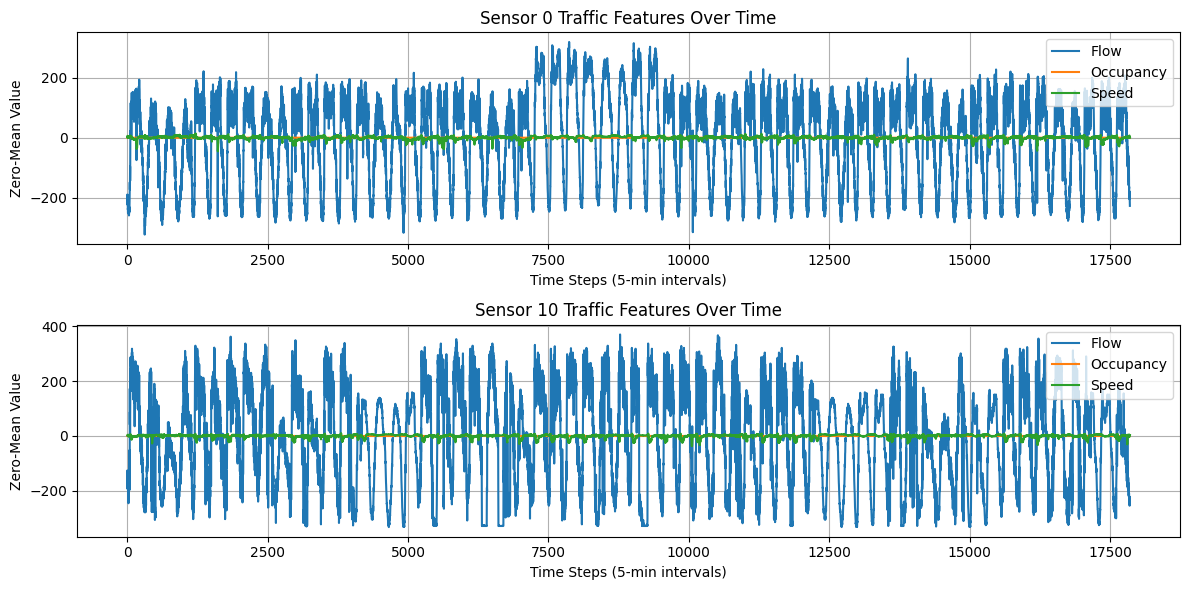

In [9]:
sensor_indices = [0, 10]  # Example sensors
features = ['Flow', 'Occupancy', 'Speed']

plt.figure(figsize=(12, 6))
for i, sensor in enumerate(sensor_indices):
    plt.subplot(len(sensor_indices), 1, i + 1)
    for f_idx, feat in enumerate(features):
        plt.plot(graph_signal_centered[:, sensor, f_idx], label=feat)
    plt.title(f'Sensor {sensor} Traffic Features Over Time')
    plt.xlabel('Time Steps (5-min intervals)')
    plt.ylabel('Zero-Mean Value')
    plt.legend(loc='upper right')
    plt.grid(True)
plt.tight_layout()
plt.show()

# Average Flow Across All Sensors

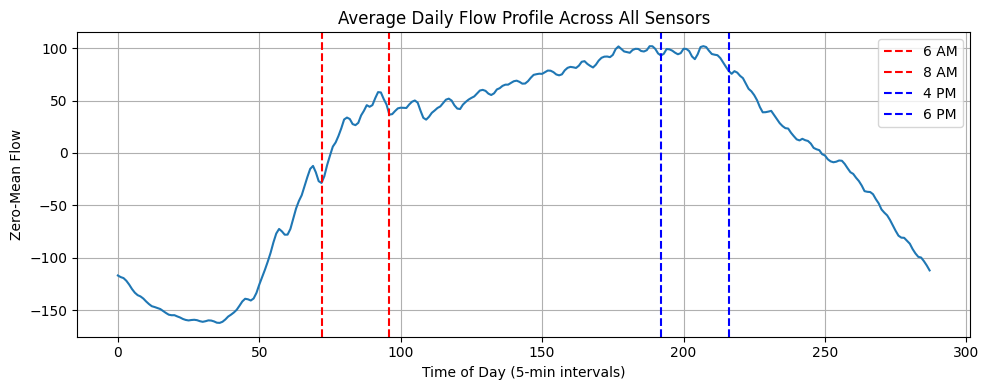

In [10]:
# Use flow feature (index 0)
flow_data = graph_signal_centered[:, :, 0]  # shape: (T, 170)

# Average across all sensors
avg_flow = flow_data.mean(axis=1)  # shape: (T,)

# Reshape into (days, 288) to see daily profiles
points_per_day = 288
num_days = graph_signal_centered.shape[0] // points_per_day
daily_profiles = avg_flow[:num_days * points_per_day].reshape(num_days, points_per_day)

# Average across days
mean_daily_profile = daily_profiles.mean(axis=0)

# Plot
plt.figure(figsize=(10, 4))
plt.plot(mean_daily_profile)
plt.title("Average Daily Flow Profile Across All Sensors")
plt.xlabel("Time of Day (5-min intervals)")
plt.ylabel("Zero-Mean Flow")
plt.axvline(72, color='red', linestyle='--', label='6 AM')
plt.axvline(96, color='red', linestyle='--', label='8 AM')
plt.axvline(192, color='blue', linestyle='--', label='4 PM')
plt.axvline(216, color='blue', linestyle='--', label='6 PM')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Distribution of Flow Values

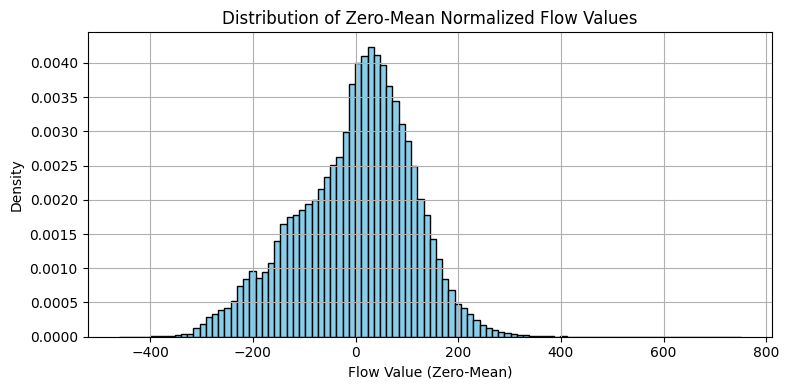

In [11]:
flow_vals = graph_signal_centered[:, :, 0].flatten()  # All flow values

plt.figure(figsize=(8, 4))
plt.hist(flow_vals, bins=100, color='skyblue', edgecolor='k', density=True)
plt.title("Distribution of Zero-Mean Normalized Flow Values")
plt.xlabel("Flow Value (Zero-Mean)")
plt.ylabel("Density")
plt.grid(True)
plt.tight_layout()
plt.show()

# Split Data Into Train and Test

In [12]:
points_per_day = 288  # 12 points/hour × 24 hours
train_days = 50
test_days = 12

train_points = train_days * points_per_day  # 14400
test_points = test_days * points_per_day    # 3456

train_data = graph_signal_centered[:train_points]
test_data = graph_signal_centered[train_points:train_points + test_points]

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (14400, 170, 3)
Test data shape: (3456, 170, 3)


# Create Dataset For Modeling

In [13]:
def create_dataset(data, num_his, num_pred):
    X, Y = [], []
    for t in range(len(data) - num_his - num_pred):
        X.append(data[t:t+num_his])
        Y.append(data[t+num_his:t+num_his+num_pred])
    return np.array(X), np.array(Y)

In [14]:
# 12-step history → 12-step prediction
X_train, Y_train = create_dataset(train_data, num_his=12, num_pred=12)
X_test, Y_test = create_dataset(test_data, num_his=12, num_pred=12)

print("X_train:", X_train.shape, "Y_train:", Y_train.shape)
print("X_test:", X_test.shape, "Y_test:", Y_test.shape)

X_train: (14376, 12, 170, 3) Y_train: (14376, 12, 170, 3)
X_test: (3432, 12, 170, 3) Y_test: (3432, 12, 170, 3)


# Loading The Data For Modeling

In [15]:
X_train_t = torch.tensor(X_train, dtype=torch.float32)  # (14376, 12, 170, 3)
Y_train_t = torch.tensor(Y_train, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
Y_test_t = torch.tensor(Y_test, dtype=torch.float32)

batch_size = 64
train_dataset = TensorDataset(X_train_t, Y_train_t)
test_dataset = TensorDataset(X_test_t, Y_test_t)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Create First Model

In [90]:
class GCNLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x, adj):
        # x: (batch_size * time_steps, num_sensors, in_features)
        # adj: (num_sensors, num_sensors)
        x = torch.matmul(adj, x)  # graph convolution
        x = self.linear(x)
        return F.relu(x)

class GCN_LSTM(nn.Module):
    def __init__(self, num_sensors=170, num_features=3, hidden_sizes=[128, 128, 128], lstm_layers=2, output_len=12, dropout=0.2):
        super(GCN_LSTM, self).__init__()
        self.output_len = output_len

        # Create multiple GCN layers
        gcn_layers = []
        in_feats = num_features
        for hidden_size in hidden_sizes:
            gcn_layers.append(GCNLayer(in_feats, hidden_size))
            in_feats = hidden_size
        self.gcn_layers = nn.ModuleList(gcn_layers)

        self.hidden_size = hidden_sizes[-1]  # last GCN layer output size

        self.lstm = nn.LSTM(self.hidden_size, self.hidden_size, num_layers=lstm_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(self.hidden_size, output_len)

    def forward(self, x, adj):
        B, T, N, F = x.size()
        adj = adj.to(x.device)

        # Reshape for GCN: merge batch & time, keep sensors and features
        x = x.permute(0, 1, 3, 2).contiguous()  # (B, T, F, N)
        x = x.view(B * T, F, N).permute(0, 2, 1)  # (B*T, N, F)

        # Pass through stacked GCN layers
        for gcn in self.gcn_layers:
            x = gcn(x, adj)  # (B*T, N, hidden_size)

        x = x.view(B, T, N, self.hidden_size)

        # Temporal modeling per sensor
        x = x.permute(0, 2, 1, 3).contiguous()  # (B, N, T, hidden_size)
        x = x.view(B * N, T, self.hidden_size)  # (B*N, T, hidden_size)

        out, _ = self.lstm(x)                    # (B*N, T, hidden_size)
        out = out[:, -1, :]                      # (B*N, hidden_size)

        out = self.fc(out)                       # (B*N, output_len)
        out = out.view(B, N, self.output_len)   # (B, N, output_len)
        out = out.permute(0, 2, 1).unsqueeze(-1)  # (B, output_len, N, 1)
        return out

# Train

In [91]:
def train_one_epoch(model, loader, optimizer, criterion, device, adj_tensor):
    model.train()
    total_loss = 0
    for X_batch, Y_batch in loader:
        X_batch, Y_batch = X_batch.to(device), Y_batch[..., 0:1].to(device)
        optimizer.zero_grad()
        Y_pred = model(X_batch, adj_tensor)
        loss = criterion(Y_pred, Y_batch)  # MSE loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

# Evaluate

In [92]:
def evaluate(model, loader, device, adj_tensor):
    model.eval()
    rmse_metric = MeanSquaredError(squared=False).to(device)
    mae_metric = MeanAbsoluteError().to(device)
    rmse_metric.reset()
    mae_metric.reset()

    with torch.no_grad():
        for X_batch, Y_batch in tqdm(loader, desc="Evaluating", leave=False):
            X_batch = X_batch.to(device)
            Y_batch = Y_batch[..., 0:1].to(device)

            Y_pred = model(X_batch, adj_tensor)  # Pass adj_tensor here

            Y_pred = Y_pred.contiguous()
            Y_batch = Y_batch.contiguous()

            rmse_metric.update(Y_pred, Y_batch)
            mae_metric.update(Y_pred, Y_batch)

    rmse = rmse_metric.compute().item()
    mae = mae_metric.compute().item()
    return rmse, mae

In [93]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = GCN_LSTM(num_sensors=170, num_features=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

epochs = 10
train_mse_losses = []
test_rmses = []
test_maes = []

for epoch in range(epochs):
    # Training step — using MSE as loss
    model.train()
    total_loss = 0
    for X_batch, Y_batch in train_loader:
        X_batch = X_batch.to(device)
        Y_batch = Y_batch[..., 0:1].to(device)

        optimizer.zero_grad()
        Y_pred = model(X_batch, adj_tensor)
        loss = criterion(Y_pred, Y_batch)  # MSE Loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    train_mse = total_loss / len(train_loader)
    train_mse_losses.append(train_mse)

    # Evaluation step — using RMSE and MAE as metrics
    test_rmse, test_mae = evaluate(model, test_loader, device, adj_tensor)
    test_rmses.append(test_rmse)
    test_maes.append(test_mae)

    print(f"Epoch {epoch+1}/{epochs} | Train MSE: {train_mse:.4f} | "
          f"Test RMSE: {test_rmse:.4f} | Test MAE: {test_mae:.4f}")

Epoch 1/10 | Train MSE: 10056.0562 | Test RMSE: 91.4516 | Test MAE: 69.0389


Epoch 2/10 | Train MSE: 7233.5812 | Test RMSE: 79.8129 | Test MAE: 59.3703


Epoch 3/10 | Train MSE: 5809.5105 | Test RMSE: 72.7831 | Test MAE: 54.4291


Epoch 4/10 | Train MSE: 5024.5396 | Test RMSE: 68.4154 | Test MAE: 51.4858


Epoch 5/10 | Train MSE: 4538.7794 | Test RMSE: 65.6081 | Test MAE: 49.5874


Epoch 6/10 | Train MSE: 4252.2916 | Test RMSE: 63.4279 | Test MAE: 48.0956


Epoch 7/10 | Train MSE: 3992.2739 | Test RMSE: 61.9079 | Test MAE: 47.0288


Epoch 8/10 | Train MSE: 3801.8285 | Test RMSE: 60.5802 | Test MAE: 46.1509


Epoch 9/10 | Train MSE: 3665.3979 | Test RMSE: 59.6583 | Test MAE: 45.4408


Epoch 10/10 | Train MSE: 3553.4444 | Test RMSE: 59.4069 | Test MAE: 45.5477


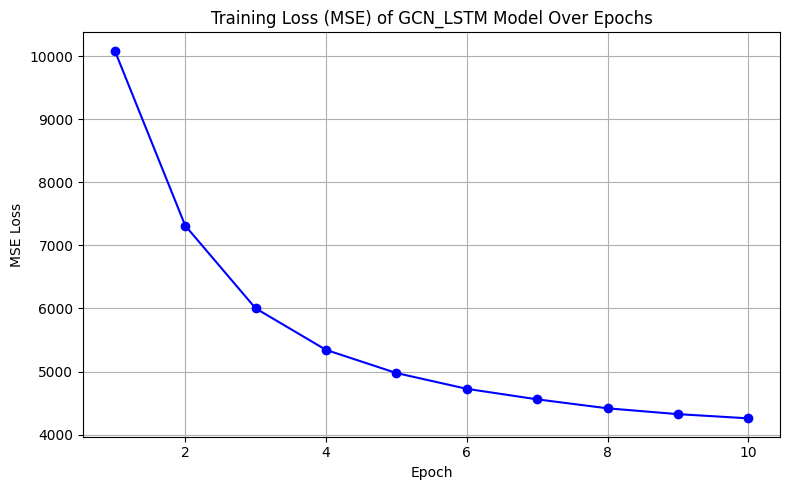

In [94]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', color='blue')
plt.title("Training Loss (MSE) of GCN_LSTM Model Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

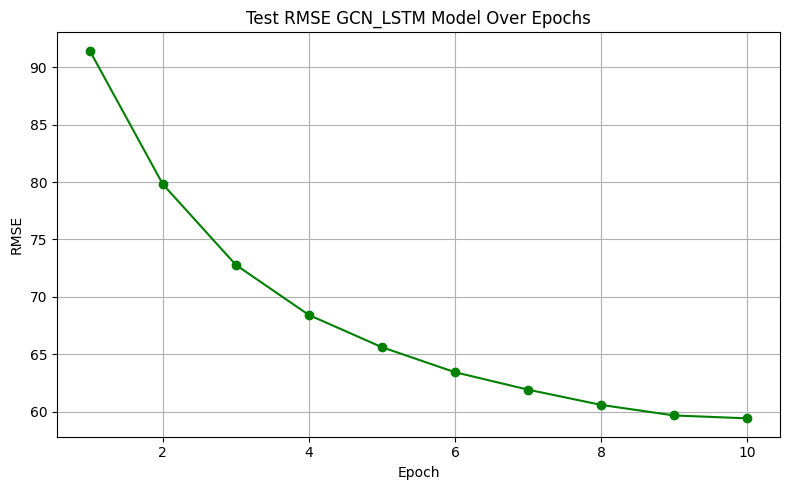

In [95]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(test_rmses) + 1), test_rmses, marker='o', color='green')
plt.title("Test RMSE GCN_LSTM Model Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.grid(True)
plt.tight_layout()
plt.show()

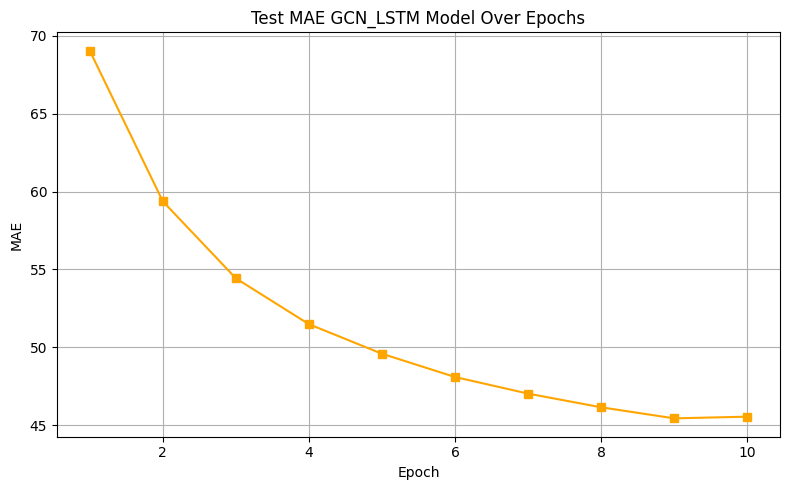

In [96]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(test_maes) + 1), test_maes, marker='s', color='orange')
plt.title("Test MAE GCN_LSTM Model Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.grid(True)
plt.tight_layout()
plt.show()

# Create Another Model

In [97]:
class GCN_GRU(nn.Module):
    def __init__(self, num_sensors=170, num_features=3, hidden_sizes=[128, 128, 128], gru_layers=2, output_len=12, dropout=0.2):
        super(GCN_GRU, self).__init__()
        self.output_len = output_len

        # Stack multiple GCN layers
        gcn_layers = []
        in_feats = num_features
        for hidden_size in hidden_sizes:
            gcn_layers.append(GCNLayer(in_feats, hidden_size))
            in_feats = hidden_size
        self.gcn_layers = nn.ModuleList(gcn_layers)

        self.hidden_size = hidden_sizes[-1]  # last GCN layer output size

        self.gru = nn.GRU(self.hidden_size, self.hidden_size, num_layers=gru_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(self.hidden_size, output_len)

    def forward(self, x, adj):
        B, T, N, F = x.size()
        adj = adj.to(x.device)

        x = x.permute(0, 1, 3, 2).contiguous()    # (B, T, F, N)
        x = x.view(B * T, F, N).permute(0, 2, 1)  # (B*T, N, F)

        # Pass through stacked GCN layers
        for gcn in self.gcn_layers:
            x = gcn(x, adj)  # (B*T, N, hidden_size)

        x = x.view(B, T, N, self.hidden_size)

        x = x.permute(0, 2, 1, 3).contiguous()    # (B, N, T, hidden_size)
        x = x.view(B * N, T, self.hidden_size)    # (B*N, T, hidden_size)

        out, _ = self.gru(x)                      # (B*N, T, hidden_size)
        out = out[:, -1, :]                       # (B*N, hidden_size)
        out = self.fc(out)                        # (B*N, output_len)

        out = out.view(B, N, self.output_len).permute(0, 2, 1).unsqueeze(-1)  # (B, output_len, N, 1)
        return out

In [98]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_gru = GCN_GRU(num_sensors=170, num_features=3).to(device)
optimizer = torch.optim.Adam(model_gru.parameters(), lr=0.001)
criterion = nn.MSELoss()

epochs = 10
train_mse_losses = []
test_rmses = []
test_maes = []

for epoch in range(epochs):
    # Training step — using MSE as loss
    model_gru.train()
    total_loss = 0
    for X_batch, Y_batch in train_loader:
        X_batch = X_batch.to(device)
        Y_batch = Y_batch[..., 0:1].to(device)

        optimizer.zero_grad()
        Y_pred = model_gru(X_batch, adj_tensor)
        loss = criterion(Y_pred, Y_batch)  # MSE Loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    train_mse = total_loss / len(train_loader)
    train_mse_losses.append(train_mse)

    # Evaluation step — using RMSE and MAE as metrics
    test_rmse, test_mae = evaluate(model_gru, test_loader, device, adj_tensor)
    test_rmses.append(test_rmse)
    test_maes.append(test_mae)

    print(f"Epoch {epoch+1}/{epochs} | Train MSE: {train_mse:.4f} | "
          f"Test RMSE: {test_rmse:.4f} | Test MAE: {test_mae:.4f}")

Epoch 1/10 | Train MSE: 10154.3516 | Test RMSE: 92.6199 | Test MAE: 70.0797


Epoch 2/10 | Train MSE: 7425.6038 | Test RMSE: 80.8876 | Test MAE: 60.1971


Epoch 3/10 | Train MSE: 5952.3954 | Test RMSE: 73.6155 | Test MAE: 54.9608


Epoch 4/10 | Train MSE: 5130.6465 | Test RMSE: 69.0770 | Test MAE: 52.0791


Epoch 5/10 | Train MSE: 4638.5589 | Test RMSE: 66.1861 | Test MAE: 50.0156


Epoch 6/10 | Train MSE: 4297.1206 | Test RMSE: 63.9658 | Test MAE: 48.6652


Epoch 7/10 | Train MSE: 4055.3420 | Test RMSE: 62.6991 | Test MAE: 47.5153


Epoch 8/10 | Train MSE: 3863.7120 | Test RMSE: 60.9604 | Test MAE: 46.2868


Epoch 9/10 | Train MSE: 3717.4373 | Test RMSE: 60.5532 | Test MAE: 46.0768


Epoch 10/10 | Train MSE: 3606.5869 | Test RMSE: 59.2396 | Test MAE: 45.2731


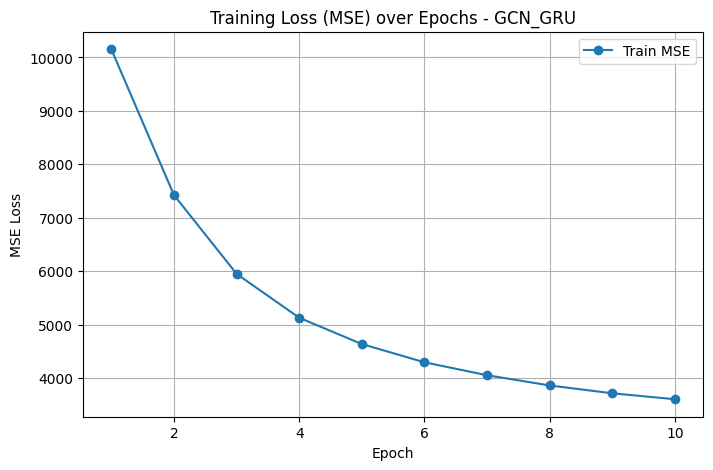

In [99]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs+1), train_mse_losses, marker='o', label='Train MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss (MSE) over Epochs - GCN_GRU')
plt.grid(True)
plt.legend()
plt.show()

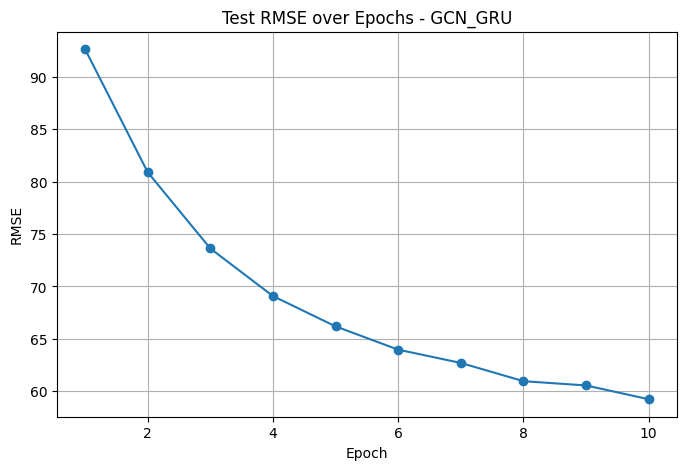

In [100]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs+1), test_rmses, marker='o', label='Test RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Test RMSE over Epochs - GCN_GRU')
plt.grid(True)
plt.show()

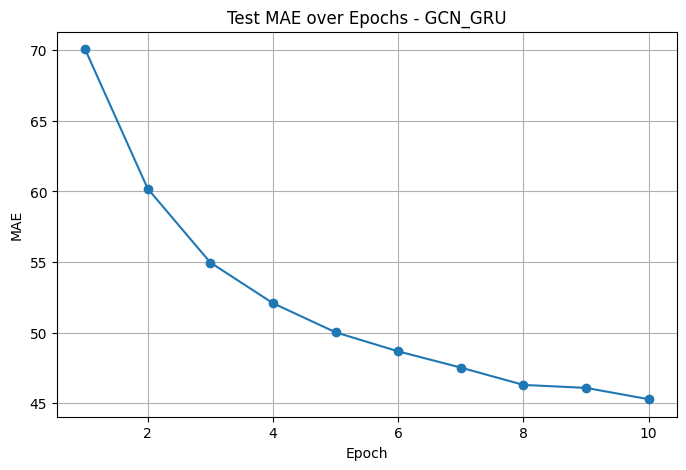

In [101]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs+1), test_maes, marker='o', label='Test MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Test MAE over Epochs - GCN_GRU')
plt.grid(True)
plt.show()